In [ ]:
from IPython.display import Image
Image("../input/landmark-recognition-2020/train/0/0/0/0000059611c7d079.jpg")

***Google Landmark Recognition 2020***

Label famous (and not-so-famous) landmarks in images

This is he third Landmark Recognition competition of the series. Did you ever go through your vacation photos and ask yourself: What is the name of this temple I visited in China? Who created this monument I saw in France? Landmark recognition can help! This technology can predict landmark labels directly from image pixels, to help people better understand and organize their photo collections. This competition challenges Kagglers to build models that recognize the correct landmark (if any) in a dataset of challenging test images.



**Note - This is an ongoing work and I will keep adding more section as time progresses**

**Credits ** [medium](https://towardsdatascience.com/histograms-in-image-processing-with-skimage-python-be5938962935)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from glob import glob
import gc
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image,display
import seaborn as sns
import matplotlib.image as mpimg
import scipy.spatial.distance as dist
from sklearn.model_selection import train_test_split
from skimage.measure import compare_ssim
import os

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train = pd.read_csv('/kaggle/input/landmark-recognition-2020/train.csv')
train.shape

In [ ]:
train.head()

**Let's check for any missing values in the train label df**

In [ ]:
missing = train.isnull().sum()
all_val = train.count()

missing_train = pd.concat([missing, all_val], axis=1, keys=['Missing', 'AllObservations'])
missing_train

Looks all good.

**Let's look at the class distribution**

In [ ]:
## Distinct classes
print("Distinct number of classes is :" + str(train['landmark_id'].nunique()))

In [ ]:
plt.figure(figsize = (8, 8))
plt.title('Landmark Classes Density plot')
sns.kdeplot(train['landmark_id'], color="blue", shade=True)
plt.show()

Looks even with no such long tails on either side. Let's look at cummulative distribution and see how image counts by classes contribute towards total images

In [ ]:
landmark_id_count = pd.DataFrame(train.groupby(['landmark_id'])['landmark_id'].count())
landmark_id_count.rename(columns={'landmark_id': 'Count_Images'}, inplace=True)
landmark_id_count.reset_index(inplace=True)
landmark_id_count.sort_values(by=['Count_Images'],ascending=False, inplace=True)
landmark_id_count['Cummulative_Count'] = landmark_id_count['Count_Images'].cumsum()
landmark_id_count['Cummulative_Pctg']= landmark_id_count['Cummulative_Count']/landmark_id_count['Count_Images'].sum()
landmark_id_count['Row_id'] = np.arange(len(landmark_id_count))
fig = plt.figure()
ax = plt.axes()
ax.plot(landmark_id_count['Row_id'], landmark_id_count['Cummulative_Pctg']);
ax.set(xlabel='Count of Classes', ylabel='Cummulative %',
       title='Cummulative distribution of images by class count');

**Top 10 landmarks with most images in the train set**

In [ ]:
landmark_id_count[['landmark_id','Count_Images']].head(10)

Landmark id  '138982' has more than 6000 images. Other than Top 7 clasess in this table, every other class has less than 1000 images

In [ ]:
print("Number of classes that contribute 95% of total images is: "+ str(len(landmark_id_count[landmark_id_count['Cummulative_Pctg']<=0.95])))
print("Number of classes that contribute 99% of total images is: "+ str(len(landmark_id_count[landmark_id_count['Cummulative_Pctg']<=0.99])))
print(str(train['landmark_id'].nunique()- len(landmark_id_count[landmark_id_count['Cummulative_Pctg']<=0.99]))+ " Classes contribute just about remaining 1% of images")
print("Number of classes with just two images is:"+ str(len(landmark_id_count[landmark_id_count['Count_Images']<=2])))

**Looks like a nice evenly distributed classes of images. Let's look at some sample images from classes where we have got lot of data vs. less data**

In [ ]:
mainPath = '/kaggle/input/landmark-recognition-2020/train/'
all_img_paths = [y for x in os.walk(mainPath) for y in glob(os.path.join(x[0], '*.jpg'))]
all_filenames = []
for filepath in all_img_paths:
    FileName = os.path.basename(filepath)
    all_filenames.append(FileName)
path_dict = dict(zip(all_filenames,all_img_paths))

In [ ]:
##Getting the list of ids where top 5 and bottom 5 categories
top5_cats = landmark_id_count[landmark_id_count['Row_id']<=4].landmark_id.tolist()
bottom5_cats = landmark_id_count[landmark_id_count['Row_id']>=(landmark_id_count['Row_id'].max()-4)].landmark_id.tolist()

In [ ]:
print("Top 5 image categories are : " + str(top5_cats))
print("Bottom 5 image categories are : " + str(bottom5_cats))

**Looking at Top 5 categories with 4 images each**

These are samples of Landmarks where we have got lot of images

In [ ]:
train['image']=train['id']+str(".jpg")

In [ ]:
for img_cat in top5_cats:
    process_img_lst = train[train['landmark_id']==img_cat].image.tolist()[0:4]
    full_img_paths = [path_dict[x] for x in process_img_lst]
    print("Sample image in Category:" + str(img_cat))
    img0 = mpimg.imread(full_img_paths[0])
    img1 = mpimg.imread(full_img_paths[1])
    img2 = mpimg.imread(full_img_paths[2])
    img3 = mpimg.imread(full_img_paths[3])
    
    fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
    ax0.imshow(img0)
    ax0.set_title("Image 1")
    ax1.imshow(img1)
    ax1.set_title("Image 2")
    ax2.imshow(img2)
    ax2.set_title("Image 3")
    ax3.imshow(img3)
    ax3.set_title("Image 4")
    plt.show()
        
    

**Lets look at some samples which have only 2 images per categories.**

These are the images that will need creative data augmentation strategy to handle class imbalance

In [ ]:
for img_cat in bottom5_cats:
    process_img_lst = train[train['landmark_id']==img_cat].image.tolist()[0:2]
    full_img_paths = [path_dict[x] for x in process_img_lst]
    print("Sample image in Category:" + str(img_cat))
    img0 = mpimg.imread(full_img_paths[0])
    img1 = mpimg.imread(full_img_paths[1])
        
    fig, ((ax0,ax1)) = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
    ax0.imshow(img0)
    ax0.set_title("Image 1")
    ax1.imshow(img1)
    ax1.set_title("Image 2")
   
    plt.show()
        

It looks like that for many of these classes that have just two images in the training data, are that of the exact same place with different orientation. Let's check the same samples that we visualized above

We will use structural similarity to do an initial assesment of this.

In [ ]:
for img_cat in bottom5_cats:
    process_img_lst = train[train['landmark_id']==img_cat].image.tolist()[0:2]
    full_img_paths = [path_dict[x] for x in process_img_lst]
    print("Structural similarity between images in Category:" + str(img_cat))
    img0 = cv2.imread(full_img_paths[0])
    img0 = cv2.resize(img0, (512, 512)) 
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img1 = cv2.imread(full_img_paths[1])
    img1 = cv2.resize(img1, (512, 512)) 
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    (score, diff) = compare_ssim(img0, img1, full=True)
    diff = (diff * 255).astype("uint8")
    print("SSIM: {}".format(score))
    

Comparing the same set of 4 images  in classes where we have lots of data (we printed them in the previous cells)

In [ ]:
for img_cat in top5_cats:
    process_img_lst = train[train['landmark_id']==img_cat].image.tolist()[0:4]
    full_img_paths = [path_dict[x] for x in process_img_lst]
    print("Structural similarity between images in Category:" + str(img_cat))
    img0 = cv2.imread(full_img_paths[0])
    img0 = cv2.resize(img0, (512, 512)) 
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img1 = cv2.imread(full_img_paths[1])
    img1 = cv2.resize(img1, (512, 512)) 
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.imread(full_img_paths[2])
    img2 = cv2.resize(img2, (512, 512)) 
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img3 = cv2.imread(full_img_paths[3])
    img3 = cv2.resize(img3, (512, 512)) 
    img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    
    (score, diff) = compare_ssim(img0, img1, full=True)
    diff = (diff * 255).astype("uint8")
    print("SSIM between first two: {}".format(score))
    (score, diff) = compare_ssim(img2, img3, full=True)
    diff = (diff * 255).astype("uint8")
    print("SSIM between last two: {}".format(score))

The structural similarity of the Image classes with more data are generally a bit lower than the classes with just two images. This could mean that the classes with more images have a wide variety of images and shots. Let's explore this in bit more details.

Let's see if we can use SSIM to find any similar images in the test set

In [ ]:
mainTestPath = '/kaggle/input/landmark-recognition-2020/test/'
all_Testimg_paths = [y for x in os.walk(mainTestPath) for y in glob(os.path.join(x[0], '*.jpg'))]
all_Testfilenames = []
for filepath in all_Testimg_paths:
    FileName = os.path.basename(filepath)
    all_Testfilenames.append(FileName)
path_dict_test = dict(zip(all_Testfilenames,all_Testimg_paths))

In [ ]:
process_img_lst = train[train['landmark_id']==bottom5_cats[0]].image.tolist()[0]
full_img_paths = path_dict[process_img_lst]
print("calculating Structural similarity with all test images:" )
img0 = cv2.imread(full_img_paths)
img0 = cv2.resize(img0, (512, 512)) 
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
test_img_ssim = {}
for filepath in all_Testimg_paths:

    FileName = os.path.basename(filepath)
    img2 = cv2.imread(filepath)
    img2 = cv2.resize(img2, (512, 512)) 
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    (score, diff) = compare_ssim(img0, img2, full=True)
    diff = (diff * 255).astype("uint8")
    test_img_ssim[FileName]=score

In [ ]:
most_sim_test =max(test_img_ssim, key=test_img_ssim.get)
print(most_sim_test,path_dict_test[most_sim_test])

In [ ]:
process_img_lst = train[train['landmark_id']==bottom5_cats[0]].image.tolist()[0]
full_img_paths = path_dict[process_img_lst]
img0 = cv2.imread(full_img_paths)
img1 = cv2.imread(path_dict_test[most_sim_test])

fig, ((ax0,ax1)) = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
ax0.imshow(img0)
ax0.set_title("Train Image")
ax1.imshow(img1)
ax1.set_title("Test Image")

plt.show()

**This is quite funny!! There is no apparent similarity in the two raw images. Maybe it has something to do  with resizing and COLOR_BGR2GRAY transformation we did. Let's implement those and review the images again**

In [ ]:
process_img_lst = train[train['landmark_id']==bottom5_cats[0]].image.tolist()[0]
full_img_paths = path_dict[process_img_lst]
img0 = cv2.imread(full_img_paths)
img0 = cv2.resize(img0, (512, 512)) 
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
img1 = cv2.imread(path_dict_test[most_sim_test])
img1 = cv2.resize(img1, (512, 512)) 
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

fig, ((ax0,ax1)) = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
ax0.imshow(img0)
ax0.set_title("Train Image")
ax1.imshow(img1)
ax1.set_title("Test Image")

plt.show()

**Looks like our hypothesis was true to some extent. Looks like by reszing the test image, we stretched the section of helicopter blades and that has lot of similarity with the cross at the top of the Church. Furthermore there are more sections in the sky in test image that now look very similar to parts of train image. Morale of the story - we need to be careful with the transformations so that we don't distort the images too much**

**Structural similarity isn't quite able to give us any more details into similarity/difference between images. Let's look at some other ways to investigate this.**

Let's plot intensity histograms to see this in more details

In [ ]:
img0 = cv2.imread(full_img_paths)

train_hist = plt.hist(img0.ravel(), bins = 256, color = 'orange', )
train_hist = plt.hist(img0[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
train_hist = plt.hist(img0[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
train_hist = plt.hist(img0[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
train_hist = plt.xlabel('Intensity Value')
train_hist = plt.ylabel('Count')
train_hist = plt.legend(['Total', 'Red Channel', 'Green Channel', 'Blue Channel'])
print('Intensity Histogram of Train Image')
plt.show()

Let's do a similar plot for the selected test image that had the highest Structural similarity with the train image

In [ ]:
img1 = cv2.imread(path_dict_test[most_sim_test])

test_hist = plt.hist(img1.ravel(), bins = 256, color = 'orange', )
test_hist = plt.hist(img1[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
test_hist = plt.hist(img1[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
test_hist = plt.hist(img1[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
test_hist = plt.xlabel('Intensity Value')
test_hist = plt.ylabel('Count')
test_hist = plt.legend(['Total', 'Red Channel', 'Green Channel', 'Blue Channel'])
print('Intensity Histogram of Test Image')
plt.show()

These two images don't look that similar anymore. 

Let's look at similar plots for one of the minority classes where we had just two pictures each.

In [ ]:
process_img_lst = train[train['landmark_id']==bottom5_cats[0]].image.tolist()[0:2]
full_img_paths = [path_dict[x] for x in process_img_lst]
print("Images in Category:" + str(img_cat))
img0 = cv2.imread(full_img_paths[0])
img1 = cv2.imread(full_img_paths[1])
fig, ((ax0,ax1)) = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
ax0.imshow(img0)
ax0.set_title("First Image")
ax1.imshow(img1)
ax1.set_title("Second Image")

plt.show()

**Let's look at Intensity Histograms of these two images one by one**

In [ ]:
process_img_lst = train[train['landmark_id']==bottom5_cats[0]].image.tolist()[0:2]
full_img_paths = [path_dict[x] for x in process_img_lst]
print("Intensity Histogram for images in Category:" + str(img_cat))
print('Intensity Histogram of First Image')
img0 = cv2.imread(full_img_paths[0])
img1 = cv2.imread(full_img_paths[1])
img_hist0 = plt.hist(img0.ravel(), bins = 256, color = 'orange', )
img_hist0 = plt.hist(img0[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
img_hist0 = plt.hist(img0[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
img_hist0 = plt.hist(img0[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
img_hist0 = plt.xlabel('Intensity Value')
img_hist0 = plt.ylabel('Count')
img_hist0 = plt.legend(['Total', 'Red Channel', 'Green Channel', 'Blue Channel'])


In [ ]:
print("Intensity Histogram for images in Category:" + str(img_cat))
print('Intensity Histogram of Second Image')
img1 = cv2.imread(full_img_paths[1])
img_hist1 = plt.hist(img1.ravel(), bins = 256, color = 'orange', )
img_hist1 = plt.hist(img1[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
img_hist1 = plt.hist(img1[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
img_hist1 = plt.hist(img1[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
img_hist1 = plt.xlabel('Intensity Value')
img_hist1 = plt.ylabel('Count')
img_hist1 = plt.legend(['Total', 'Red Channel', 'Green Channel', 'Blue Channel'])


These two Intensity Histograms look much more similar visually in their color profile. 

Let's look at two images from majority classes as well to confirm this hypothesis

In [ ]:
process_img_lst = train[train['landmark_id']==top5_cats[2]].image.tolist()[0:2]
full_img_paths = [path_dict[x] for x in process_img_lst]
print("Images in Category:" + str(img_cat))
img0 = cv2.imread(full_img_paths[0])
img1 = cv2.imread(full_img_paths[1])
fig, ((ax0,ax1)) = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
ax0.imshow(img0)
ax0.set_title("First Image")
ax1.imshow(img1)
ax1.set_title("Second Image")

plt.show()

**Let's plot the intensity histograms of these two images one by one**

In [ ]:
process_img_lst = train[train['landmark_id']==top5_cats[2]].image.tolist()[0:2]
full_img_paths = [path_dict[x] for x in process_img_lst]
print("Intensity Histogram for images in Category:" + str(img_cat))
print('Intensity Histogram of First Image')
img0 = cv2.imread(full_img_paths[0])
img_hist0 = plt.hist(img0.ravel(), bins = 256, color = 'orange', )
img_hist0 = plt.hist(img0[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
img_hist0 = plt.hist(img0[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
img_hist0 = plt.hist(img0[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
img_hist0 = plt.xlabel('Intensity Value')
img_hist0 = plt.ylabel('Count')
img_hist0 = plt.legend(['Total', 'Red Channel', 'Green Channel', 'Blue Channel'])


In [ ]:
print("Intensity Histogram for images in Category:" + str(img_cat))
print('Intensity Histogram of Second Image')
img1 = cv2.imread(full_img_paths[1])
img_hist1 = plt.hist(img1.ravel(), bins = 256, color = 'orange', )
img_hist1 = plt.hist(img1[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
img_hist1 = plt.hist(img1[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
img_hist1 = plt.hist(img1[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
img_hist1 = plt.xlabel('Intensity Value')
img_hist1 = plt.ylabel('Count')
img_hist1 = plt.legend(['Total', 'Red Channel', 'Green Channel', 'Blue Channel'])


**The similarity is quite visible in this case as well. Keeping the RGB channels in the images while training may help us capture meaningful differences in images and help train models better.**

**Now we will  make a smaller and trainable subset of images as Kaggle resources are not enough to train all images at once.**

Taking a small 10% stratified sample is also quite large for Kaggle kernel. So we will now try with top 100 classes and see how Transfer Learning works.


In [ ]:
path_df = pd.DataFrame(path_dict.items())
path_df.rename(columns={ path_df.columns[0]: "image" }, inplace = True)
path_df.rename(columns={ path_df.columns[1]: "path" }, inplace = True)
train['image']=train['id']+str(".jpg")
train_all = pd.merge(train, path_df, on='image')
del path_df,path_dict,all_img_paths,all_filenames
gc.collect()

In [ ]:
##Plz ignore the dataframe naming convention. I borrowed from my other kernel and didn't bother making changes :P
freq_ct_df_top100 = landmark_id_count.iloc[:100]
top100_class = freq_ct_df_top100['landmark_id'].tolist()
top100class_train = train_all[train_all['landmark_id'].isin (top100_class) ]

In [ ]:
def getTrainParams():
    data = top100class_train.copy()
    le = preprocessing.LabelEncoder()
    data['label'] = le.fit_transform(data['landmark_id'])
    lbls = top100class_train['landmark_id'].tolist()
    lb = LabelBinarizer()
    labels = lb.fit_transform(lbls)
    
    return np.array(top100class_train['path'].tolist()),np.array(labels),le

In [ ]:
batch_size = 64
seed = 42
shape = (224, 224, 3) ##desired shape of the image for resizing purposes
val_sample = 0.1 # 10 % as validation sample

**Lets import some libraries for creating the models**

In [ ]:
import tensorflow as tf
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D,Concatenate, ReLU, LeakyReLU,Reshape, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.xception import Xception 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tqdm import tqdm
import imgaug as ia
from imgaug import augmenters as iaa
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)


Credit to Michal Haltuf from whose kernel I had first learnt Data Generators two years back. You can check out his kernel here: https://www.kaggle.com/rejpalcz/cnn-128x128x4-keras-from-scratch-lb-0-328

In [ ]:
class Landmark2020_DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    
                    iaa.ContrastNormalization((0.75, 1.5)),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    
                    iaa.Affine(rotate=0),
                    #iaa.Affine(rotate=90),
                    #iaa.Affine(rotate=180),
                    #iaa.Affine(rotate=270),
                    iaa.Fliplr(0.5),
                    #iaa.Flipud(0.5),
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image_norm = skimage.io.imread(path)/255.0
        

        im = resize(image_norm, (shape[0], shape[1],shape[2]), mode='reflect')
        return im

In [ ]:
def create_model(input_shape, n_out):
    inp = Input(input_shape)
    pretrain_model = Xception(include_top=False, weights='imagenet', input_tensor=inp)
    #x = pretrain_model.get_layer(name="block_13_expand_relu").output
    x = pretrain_model.output
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
    x = Dense(n_out, activation="sigmoid")(x)
    
    ##Uncomment if you want to train few more layers before the head
    #for layer in pretrain_model.layers[:160]:
        #layer.trainable = False
    
    for layer in pretrain_model.layers:
        layer.trainable = False
        
    return Model(inp, x)

In [ ]:
from tensorflow.keras.metrics import categorical_accuracy,top_k_categorical_accuracy
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [ ]:
nlabls = top100class_train['landmark_id'].nunique()
model = create_model(input_shape=(224,224,3), n_out=nlabls)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',top_5_accuracy])
model.summary()

In [ ]:
paths, labels,_ = getTrainParams()
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(seed)
np.random.shuffle(keys)
lastTrainIndex = int((1-val_sample) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]

pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

In [ ]:
train_generator = Landmark2020_DataGenerator(pathsTrain, labelsTrain, batch_size, shape, use_cache=False, augment = False, shuffle = True)
val_generator = Landmark2020_DataGenerator(pathsVal, labelsVal, batch_size, shape, use_cache=False, shuffle = False)

Due to insufficient resources we can demonstrate only 1 epoch in Kaggle environment. If you try and run more than epoch, you may end up like this. I am going to load a pre-trained model for 100 classes for 5 epochs and then train for one additional epoch. Also in this version I have switched to Xception from ResNet as that was giving better results

In [ ]:
model.load_weights('/kaggle/input/xception-pass1/Xception_pass1.h5')

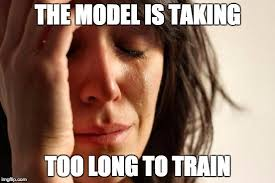

In [ ]:
#clr = CyclicLR(base_lr=0.005, max_lr=0.01,step_size=2000., mode='triangular')
epochs = 1
use_multiprocessing = True 
#workers = 6 
base_cnn = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=24,
    #class_weight = class_weights,
    epochs=epochs,
    #callbacks = [clr],
    use_multiprocessing=use_multiprocessing,
    #workers=workers,
    verbose=1)

In [ ]:
model.save('Xception_pass2.h5')

**Up Next -  Making predictions and arranging the submission file for the competition.**

**If you found this helpful - please upvote. This would motivate me to keep updating this notebook as the competition progresses further**